In [1]:
import gensim
import pickle
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fastText = gensim.models.KeyedVectors.load_word2vec_format('fastText.vec', binary=False)

In [3]:
path = "../food-life-management/"

path_title_V = os.listdir(path + 'recipe_title_V/')
path_title_V = ['recipe_title_V/' + p for p in path_title_V]
path_title_V.sort()
path_title_V = path_title_V[:10]

path_title_V = [path + p for p in path_title_V]
# print(path_title_V)

title_V = {}

for path_t_V in path_title_V:
    with open(path_t_V, 'rb') as f:
        t_V = pickle.load(f)
    title_V.update(t_V)

# 可視化
n=0
for key, v in title_V.items():
    n+=1
    print(key)
    print(v.shape)
    
    print(fastText.most_similar(positive=[v], topn=3))
    if n>7:break

print(len(title_V.items()))

menu-0000000-0010000-0000000
(256,)
[('フルーツ', 0.8731243014335632), ('ジャム', 0.8731242418289185), ('キウィフルーツ', 0.7913082838058472)]
menu-0000000-0010000-0000001
(256,)
[('豚の角煮', 0.9999998807907104), ('カチャトーラ', 0.5733411312103271), ('土佐煮', 0.5723936557769775)]
menu-0000000-0010000-0000002
(256,)
[('おはぎ', 0.7299758195877075), ('やの', 0.7299756407737732), ('茅野', 0.6305214762687683)]
menu-0000000-0010000-0000003
(256,)
[('わかめ', 0.7648988366127014), ('茎', 0.7648986577987671), ('おかわかめ', 0.6870619058609009)]
menu-0000000-0010000-0000004
(256,)
[('ピーマン', 0.7248757481575012), ('肉', 0.6988292336463928), ('肉詰めピーマン', 0.6478877067565918)]
menu-0000000-0010000-0000005
(256,)
[('エスプレッソ', 0.8271960616111755), ('プリン', 0.827195942401886), ('マンゴープリン', 0.7229130864143372)]
menu-0000000-0010000-0000006
(256,)
[('チーズ', 0.7899888157844543), ('リゾット', 0.7899888157844543), ('パルメランチーズ', 0.7318606972694397)]
menu-0000000-0010000-0000007
(256,)
[('肉じゃが', 1.0000001192092896), ('煮物', 0.5996810793876648), ('かぼちゃの煮物', 0.5

# 料理名ベクトルの分布の様子を可視化
# 実は料理名ベクトルはものすごく偏っている！

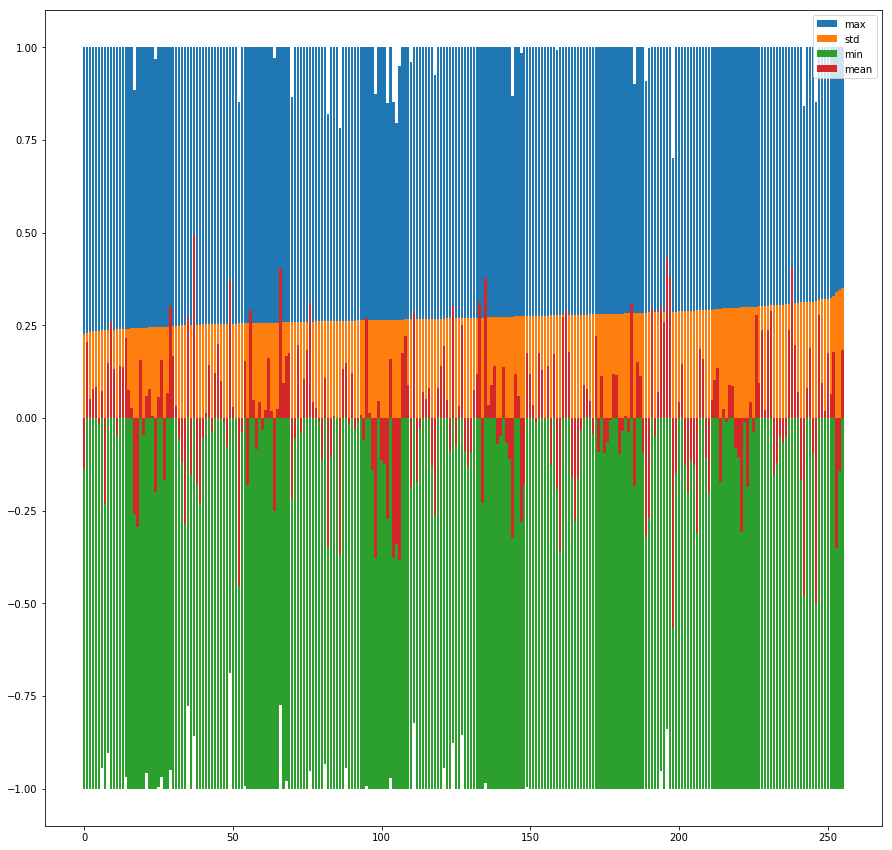

In [4]:
TT = np.array(list(title_V.values()))

plt.figure(figsize=(15,15))

TT_mean = np.mean(TT, axis=0)
TT_std = np.std(TT, axis=0)
TT_max = np.max(TT, axis=0)
TT_min = np.min(TT, axis=0)

indecise = np.argsort(TT_std)

plt.bar(np.arange(0,256), TT_max[indecise], label="max", linewidth=3)
plt.bar(np.arange(0,256), TT_std[indecise], label="std", linewidth=3)
plt.bar(np.arange(0,256), TT_min[indecise], label="min", linewidth=3)
plt.bar(np.arange(0,256), TT_mean[indecise], label="mean", linewidth=3)

plt.legend()
plt.show()

# cos類似度行列を計算する便利関数

In [5]:
def cos_sim_matrix(matrix):
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

任意2点間の平均cos_sim:  0.3063500831456533


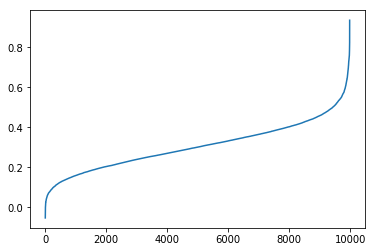

top5:  [0.79296775 0.80676535 0.81560055 0.82489118 0.93542595]
cos_sim > 0.5:  559 個
cos_sim > 0.6:  142 個
cos_sim > 0.7:  44 個
cos_sim > 0.8:  4 個
cos_sim > 0.9:  1 個


In [6]:
import random

AA = cos_sim_matrix(TT[:1000])
AA = list(AA.flatten())
AA = random.sample(AA, 10000)
AA = np.array([a for a in AA if not a > 0.999])

AA.sort()
AA = np.array([a for a in AA if not a > 0.999])
print("任意2点間の平均cos_sim: ", AA.mean())

plt.plot(AA)
plt.show()
print("top5: ", AA[-5:])
AA = np.array([a for a in AA if a > 0.5])
print("cos_sim > 0.5: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.6])
print("cos_sim > 0.6: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.7])
print("cos_sim > 0.7: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.8])
print("cos_sim > 0.8: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.9])
print("cos_sim > 0.9: ", len(AA), "個")

# 次元の呪いの影響で、
# 256次元の空間でのcos類似度0.3というのはかなり問題がある

In [7]:
X = np.array(list(title_V.values()))
print(X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1)

print(X_train.shape, X_test.shape)

(283524, 256)
(255171, 256) (28353, 256)


# AutoEncoder

In [9]:
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers

from keras import backend as K

encoding_dim = 256
inputs = Input(shape=(256,))

encoded = Dense(encoding_dim, activation='tanh',name='encoded')(inputs)
decoded = Dense(256, activation='tanh', name='decoded')(encoded)
autoencoder = Model(inputs=inputs, outputs=decoded)

encoder = K.function([autoencoder.get_layer("encoded").input],
                     [autoencoder.get_layer("encoded").output])

decoder = K.function([autoencoder.get_layer("decoded").input],
                     [autoencoder.get_layer("decoded").output])

autoencoder.compile(optimizer=optimizers.Adam(lr=1e-4), 
                    loss='cosine_proximity',)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256)               0         
_________________________________________________________________
encoded (Dense)              (None, 256)               65792     
_________________________________________________________________
decoded (Dense)              (None, 256)               65792     
Total params: 131,584
Trainable params: 131,584
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.compile(optimizer=optimizers.Adam(lr=1e-5), 
                    loss='cosine_proximity',)
hist = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

# xのtop1が、yのtop1と一致するか、top2に含まれるか、top3に含まれるか

In [11]:
# 20秒とか
samples = 1000

indecise = np.random.randint(0, len(X), samples)

topn = 10

topk = [0]*topn

for i,x in enumerate(X[indecise]):
    if i % 100 == 0:
        print(i, end=" ")
    tmp = np.array(fastText.most_similar(positive=[x], topn=topn))[0,0]
    
    [y] = autoencoder.predict(x.reshape(1,-1))
    
    pred = np.array(fastText.most_similar(positive=[y], topn=topn))[:,0]
    
    
    if tmp == pred[0]:
        for k in range(topn):
            topk[k] += 1
    elif tmp == pred[1]:
        for k in range(1,topn):
            topk[k] += 1
    elif tmp == pred[2]:
        for k in range(2,topn):
            topk[k] += 1
    elif tmp == pred[3]:
        for k in range(3,topn):
            topk[k] += 1
    elif tmp == pred[4]:
        for k in range(4,topn):
            topk[k] += 1
    elif tmp == pred[5]:
        for k in range(5,topn):
            topk[k] += 1
    elif tmp == pred[6]:
        for k in range(6,topn):
            topk[k] += 1
    elif tmp == pred[7]:
        for k in range(7,topn):
            topk[k] += 1
    elif tmp == pred[8]:
        for k in range(8,topn):
            topk[k] += 1
    elif tmp == pred[9]:
        for k in range(9,topn):
            topk[k] += 1

print()
for k in range(topn):
    topk[k] /= samples/100
for k in range(topn):
    print("top", k, ": ", topk[k], "%")


0 100 200 300 400 500 600 700 800 900 
top 0 :  83.0 %
top 1 :  99.9 %
top 2 :  100.0 %
top 3 :  100.0 %
top 4 :  100.0 %
top 5 :  100.0 %
top 6 :  100.0 %
top 7 :  100.0 %
top 8 :  100.0 %
top 9 :  100.0 %


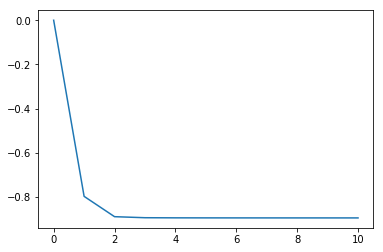

In [17]:
hist1 = [0] + hist.history["loss"]
plt.plot(hist1)
plt.show()

In [9]:
# autoencoder.save_weights("weights/4_256-64_10epochs.hdf5")
autoencoder.load_weights("weights/4_256-256_10epochs.hdf5")

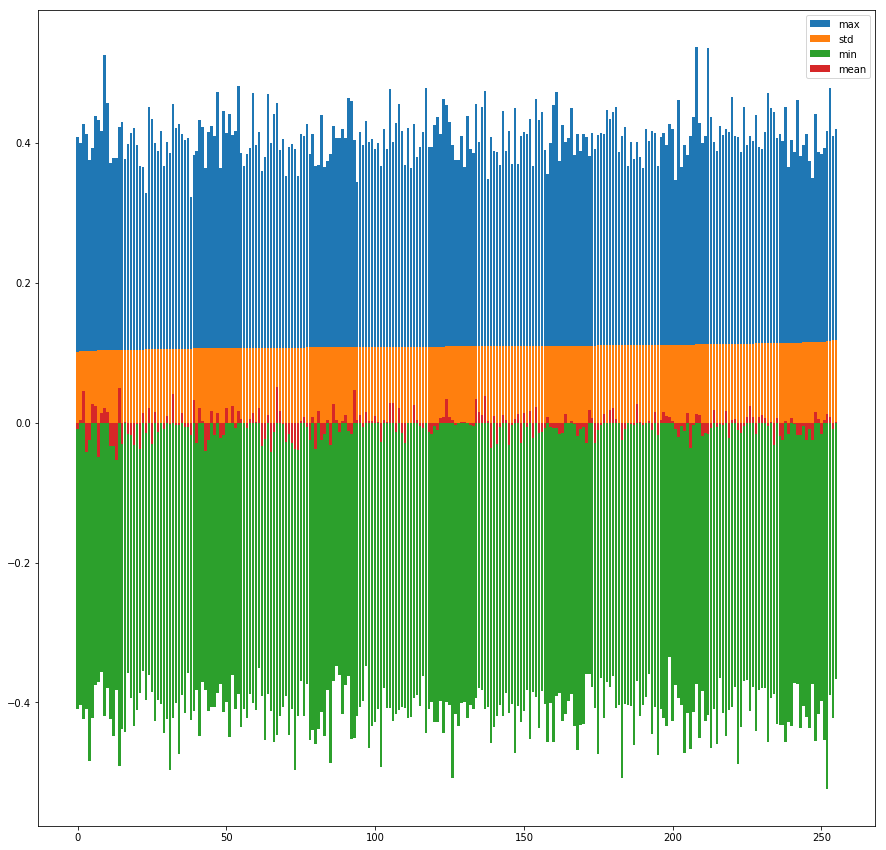

0.1092488


In [12]:
[TT] = encoder([X[:10000]])

plt.figure(figsize=(15,15))

TT_mean = np.mean(TT, axis=0)
TT_std = np.std(TT, axis=0)
TT_max = np.max(TT, axis=0)
TT_min = np.min(TT, axis=0)

indecise = np.argsort(TT_std)

plt.bar(np.arange(0,encoding_dim), TT_max[indecise], label="max", linewidth=3)
plt.bar(np.arange(0,encoding_dim), TT_std[indecise], label="std", linewidth=3)
plt.bar(np.arange(0,encoding_dim), TT_min[indecise], label="min", linewidth=3)
plt.bar(np.arange(0,encoding_dim), TT_mean[indecise], label="mean", linewidth=3)

plt.legend()
plt.show()

print(TT_std.mean())

任意2点間の平均cos_sim:  0.032189522


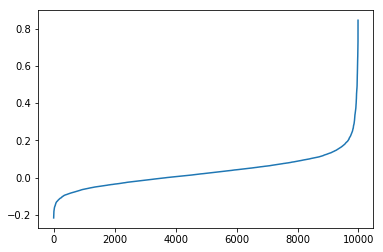

top5:  [0.69599473 0.70210403 0.72976184 0.72976184 0.8446032 ]
cos_sim > 0.5:  31 個
cos_sim > 0.6:  15 個
cos_sim > 0.7:  4 個
cos_sim > 0.8:  1 個
cos_sim > 0.9:  0 個


In [68]:
import random

[A] = encoder([X[:1000]])

AA = cos_sim_matrix(A)
AA = list(AA.flatten())
# AA = AA[:10000]
AA = random.sample(AA, 10000)
AA.sort()
AA = np.array([a for a in AA if not a > 0.999])
print("任意2点間の平均cos_sim: ", AA.mean())

plt.plot(AA)
plt.show()
print("top5: ", AA[-5:])
AA = np.array([a for a in AA if a > 0.5])
print("cos_sim > 0.5: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.6])
print("cos_sim > 0.6: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.7])
print("cos_sim > 0.7: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.8])
print("cos_sim > 0.8: ", len(AA), "個")
AA = np.array([a for a in AA if a > 0.9])
print("cos_sim > 0.9: ", len(AA), "個")

In [16]:
V = list(title_V_autoencoder.values())

for v in V[:10]:
    [[v]] = decoder([v.reshape(1,-1)])
    print(fastText.most_similar(positive=[v], topn=3))

[('ジャム', 0.8733418583869934), ('フルーツ', 0.8727586269378662), ('キウィフルーツ', 0.7911166548728943)]
[('豚の角煮', 0.9999167323112488), ('カチャトーラ', 0.5746312737464905), ('土佐煮', 0.5710816979408264)]
[('やの', 0.7315585017204285), ('おはぎ', 0.7281984686851501), ('茅野', 0.6322582960128784)]
[('茎', 0.765271782875061), ('わかめ', 0.7643400430679321), ('おかわかめ', 0.6866381168365479)]
[('ピーマン', 0.7266967296600342), ('肉', 0.6995254158973694), ('肉詰めピーマン', 0.6483163833618164)]
[('プリン', 0.8274580240249634), ('エスプレッソ', 0.8267906904220581), ('マンゴープリン', 0.7251315116882324)]
[('チーズ', 0.7910290956497192), ('リゾット', 0.7888212203979492), ('パルメランチーズ', 0.7323862910270691)]
[('肉じゃが', 0.9999223351478577), ('煮物', 0.599593997001648), ('かぼちゃの煮物', 0.5678032636642456)]
[('もち', 0.8089815378189087), ('よもぎ', 0.8074498772621155), ('よも', 0.6492825150489807)]
[('スペアリブ', 0.7804889678955078), ('梅酒', 0.780409038066864), ('チキンスペアリブ', 0.7217721343040466)]


In [17]:
for v in X[:10]:
#     [[v]] = decoder([v.reshape(1,-1)])
    print(fastText.most_similar(positive=[v], topn=3))

[('フルーツ', 0.8731243014335632), ('ジャム', 0.8731242418289185), ('キウィフルーツ', 0.7913082838058472)]
[('豚の角煮', 0.9999998807907104), ('カチャトーラ', 0.5733411312103271), ('土佐煮', 0.5723936557769775)]
[('おはぎ', 0.7299758195877075), ('やの', 0.7299756407737732), ('茅野', 0.6305214762687683)]
[('わかめ', 0.7648988366127014), ('茎', 0.7648986577987671), ('おかわかめ', 0.6870619058609009)]
[('ピーマン', 0.7248757481575012), ('肉', 0.6988292336463928), ('肉詰めピーマン', 0.6478877067565918)]
[('エスプレッソ', 0.8271960616111755), ('プリン', 0.827195942401886), ('マンゴープリン', 0.7229130864143372)]
[('チーズ', 0.7899888157844543), ('リゾット', 0.7899888157844543), ('パルメランチーズ', 0.7318606972694397)]
[('肉じゃが', 1.0000001192092896), ('煮物', 0.5996810793876648), ('かぼちゃの煮物', 0.5684722065925598)]
[('もち', 0.8082996606826782), ('よもぎ', 0.8082994222640991), ('よも', 0.6487313508987427)]
[('梅酒', 0.7805392146110535), ('スペアリブ', 0.7805390357971191), ('チキンスペアリブ', 0.7222998142242432)]


In [18]:
autoencoder.save("title_autoencoder.hdf5")